In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import sin, cos, sqrt, atan2, radians, degrees
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

In [155]:
train=pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/train.csv')
test = pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/kaggle/택시 - 복사본/sample_submission.csv')

In [156]:
print('train shape :', train.shape)
print('test shape :',test.shape)

train shape : (1458644, 11)
test shape : (625134, 9)


- ID - 각 여행에 대한 고유 식별자
- vendor_id - 여행 기록과 관련된 공급자를 나타내는 코드
- pickup_datetime - 미터가 종사한 날짜 및 시간
- dropoff_datetime - 미터가 분리된 날짜 및 시간
- passenger_count - 차량의 승객 수 (운전자가 값을 입력)
- pickup_longitude - 미터가 종사하는 경도
- pickup_latitude - 미터가 종사하는 위도
- dropoff_longitude - 미터가 분리 된 경도
- dropoff_latitude - 미터가 분리 된 위도
- store_and_fwd_flag - 이 플래그는 차량이 서버에 연결되지 않았기 때문에 공급 업체에 보내기 전에 여행 기록이 차량 메모리에 보관되었는지 여부를 나타냅니다.-Y = 저장 및 전달; N = 저장 및 전진 여행 아님
- trip_duration - 초 여행의 기간

In [157]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [158]:
print('########### train ##################')
print(train.info())

print('########### test ##################')
print(test.info())

########### train ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
########### test ##################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data

In [159]:
print('############# train 결측치 ##############')
print(train.isnull().sum())

print('############# test 결측치 ##############')
print(test.isnull().sum())

############# train 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
############# test 결측치 ##############
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


- 결측치는 모든 데이터에 없다.

In [160]:
print('####################### train ##################')
display(train.describe())

print('###################### test ###################')
display(test.describe())

####################### train ##################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


###################### test ###################


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [161]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

# trip_duration을 target으로 바꿔준다.
train=train.rename(columns = {'trip_duration':'target'})

In [162]:
def sub_function(x):
    a=set(train[x].unique())
    b =set(test[x].unique())
    a =a.difference(test[x])
    b =b.difference(train[x])
    print(f'train_set 에만 있는 값 {a}')
    print(f'test_set 에만 있는 값 {b}')    

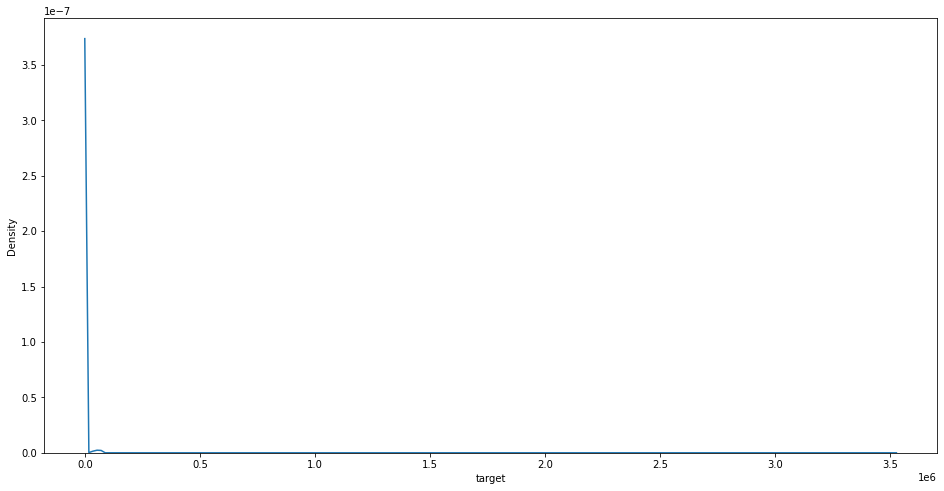

In [163]:
# target에 정규화를 시켜주고 분석을 진행해 주자.
plt.figure(figsize = (16,8))
sns.kdeplot(train['target'])

# id

In [164]:
train['id']=train['id'].apply(lambda x:x[2:])
train['id']=train['id'].astype('int')

test['id'] = test['id'].apply(lambda x: x[2:])
test['id'] = test['id'].astype('int')

In [165]:
train['id'].describe()

count    1.458644e+06
mean     1.999021e+06
std      1.154740e+06
min      1.000000e+00
25%      9.992588e+05
50%      1.998046e+06
75%      2.999228e+06
max      4.000000e+06
Name: id, dtype: float64

In [166]:
print(train['id'].min(), train['id'].max())
print(test['id'].min(), test['id'].max())

1 4000000
2 3999997


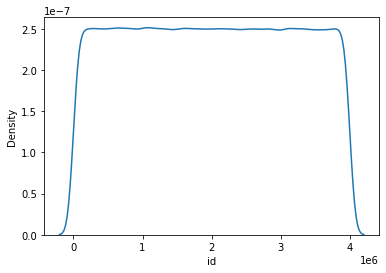

In [167]:
# 특정한 분포를 찾을 수 없으므로 이 데이터는 제거 해 주도록 하자.
sns.kdeplot(data = train, x = 'id')

## vendor_id

In [168]:
train.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

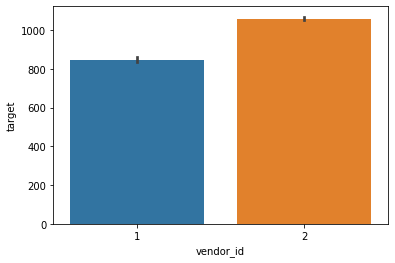

In [169]:
sns.barplot(data = train, x = 'vendor_id', y = 'target')

In [170]:
sub_function('vendor_id')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


- 이 데이터의 경우 설명도 나와 있지 않기 때문에 나중에 다른 변수와 비교할 때 사용해야 겠다.

## passenger_count

In [171]:
print('train의 passenger_count')
print(train['passenger_count'].value_counts())
print('test의 passenger_count')
print(test['passenger_count'].value_counts())

train의 passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64
test의 passenger_count
1    443447
2     90027
5     33411
3     25686
6     20521
4     12017
0        23
9         2
Name: passenger_count, dtype: int64


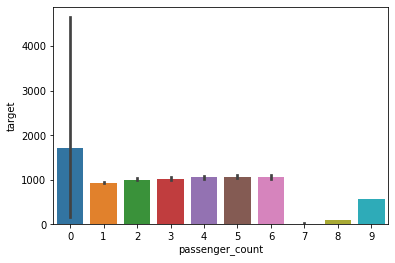

In [172]:
sns.barplot(data = train, x = 'passenger_count', y = 'target')

- 0명을 태웠다는 말은 무슨말일까?
- 일단 test셋에 7과 8이 없음으로 7과 8의 데이터를 지워주도록 하자!!

## pickup_datetime

In [173]:
def datetime(df, column):
    df['month'] = df[column].dt.month
    df['day'] = df[column].dt.day
    df['hour'] = df[column].dt.hour
    return df

In [174]:
train=datetime(df = train, column = 'pickup_datetime')
test=datetime(df = test, column = 'pickup_datetime')

In [175]:
# 주말과 평일을 나누어서 데이터를 분석해 보자.
train['weekday'] = train['pickup_datetime'].apply(lambda x:x.weekday())
train['weekday']=train['weekday'].apply(lambda x: 1 if x > 4 else 0)

test['weekday'] = test['pickup_datetime'].apply(lambda x:x.weekday())
test['weekday']=test['weekday'].apply(lambda x: 1 if x > 4 else 0)

### 평일과 공휴일의 차이

Text(0.5, 1.0, 'weekday vs target')

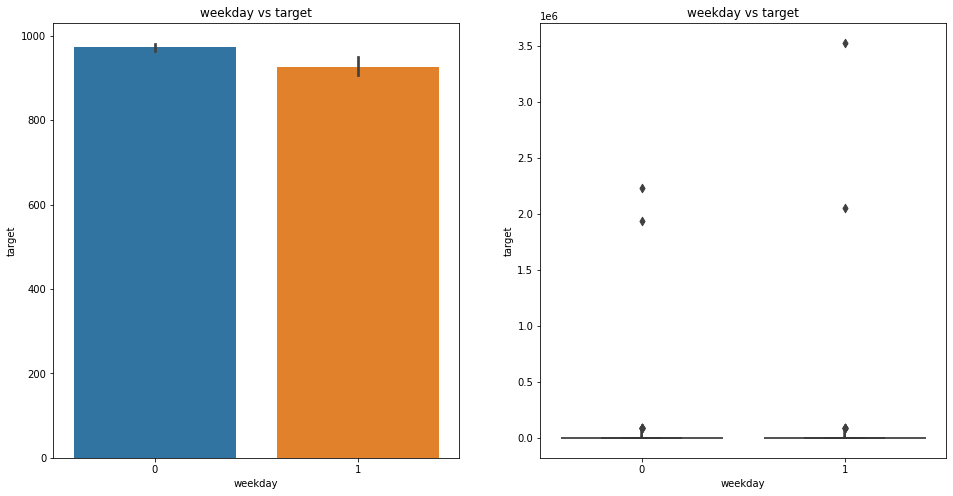

In [176]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'weekday', y = 'target', ax = ax[0])
ax[0].set_title('weekday vs target')

sns.boxenplot(data = train, x = 'weekday', y = 'target', ax = ax[1])
ax[1].set_title('weekday vs target')

- 사람들은 평일에 택시를 더 많이 타는 것을 알 수있다.

### 월별로 차이

Text(0.5, 1.0, 'month vs target')

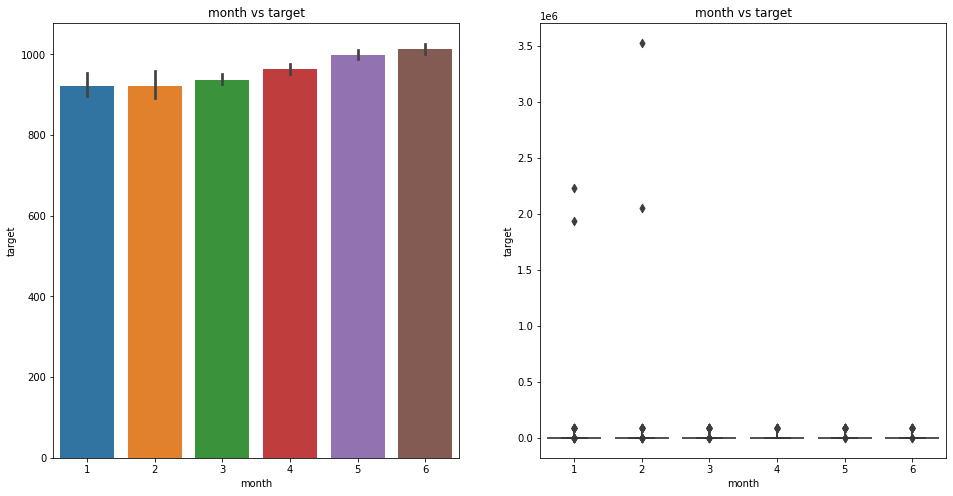

In [177]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.barplot(data = train, x = 'month', y = 'target', ax = ax[0])
ax[0].set_title('month vs target')

sns.boxenplot(data = train, x = 'month', y = 'target', ax = ax[1])
ax[1].set_title('month vs target')

- 매 달마다 택시를 타는 사람이 늘어나고 있다.

In [178]:
sub_function('month')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


### 일별로 차이

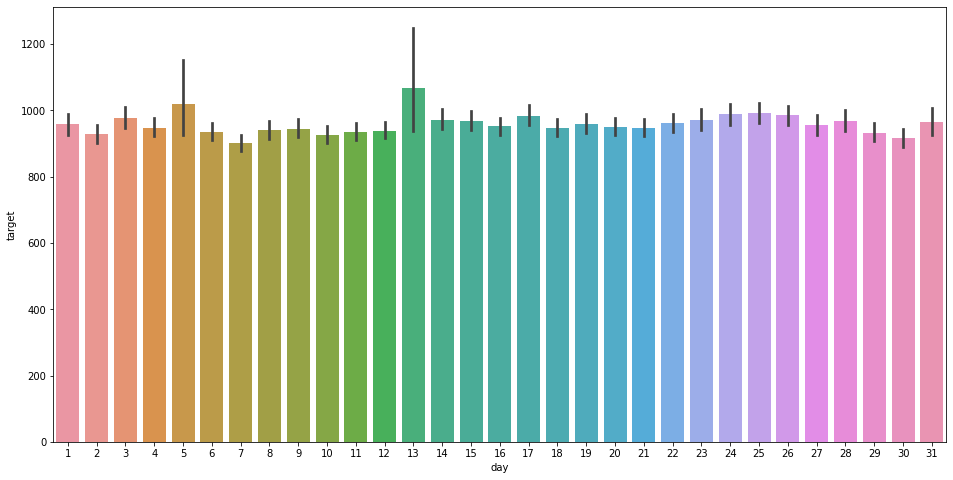

In [179]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'day', y = 'target')

- 일별로는 다른 차이점을 발견하지 못했다.

In [180]:
sub_function('day')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


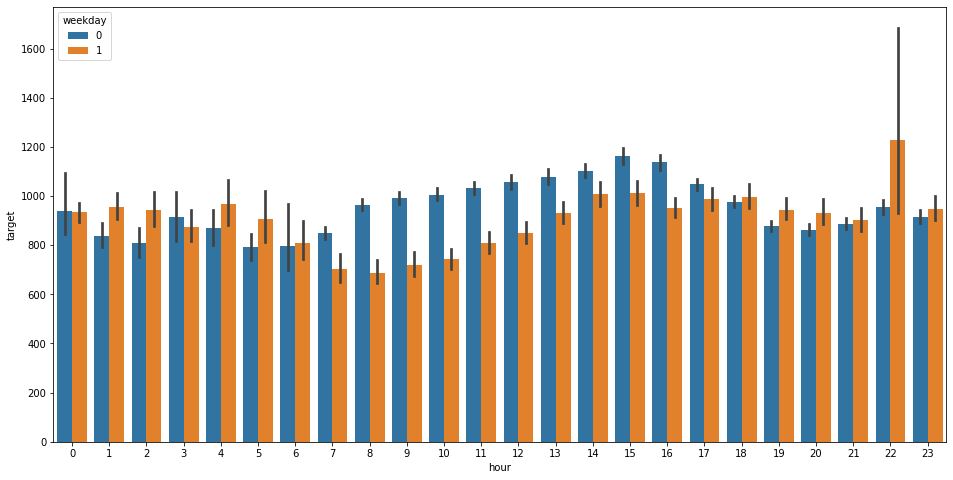

In [181]:
plt.figure(figsize = (16,8))
sns.barplot(data = train, x = 'hour', y = 'target', hue = 'weekday')

- 시간별로 공휴일인지 아닌지는 차이가 있는 것 같다.

## 위도 경도를 이용해 거리 구하기

In [182]:
!pip install haversine

In [183]:
from haversine import haversine

In [184]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'target',
       'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [185]:
def haversine1(lat1, lon1, lat2, lon2, R = 6373.0):
    
    R = R # 'km'를 나타내기위해 수를 지정해준다.
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1)*cos(lat2)*sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    distance = R * c
    return distance
    
train['distance'] = train.apply(lambda x:haversine1(x['pickup_latitude'],
                                                   x['pickup_longitude'],
                                                   x['dropoff_latitude'],
                                                   x['dropoff_longitude']
                                                   ), axis = 1)

test['distance'] = test.apply(lambda x:haversine1(x['pickup_latitude'],
                                                   x['pickup_longitude'],
                                                   x['dropoff_latitude'],
                                                   x['dropoff_longitude']
                                                   ), axis = 1)

In [186]:
# haversine을 짯지만 너무 느린관계로 쓰지 않는다.
# from tqdm import tqdm

# def haversine1(df = None):
#     for i in tqdm(df.index):
#         df.loc[i,'distance'] = haversine((df.loc[i,'pickup_longitude'],df.loc[i,'pickup_latitude']),
#                                          (df.loc[i,'dropoff_longitude'],df.loc[i,'dropoff_latitude']), unit = 'm')
#     return df

# distance_train=haversine1(df = train)
# distance_train=pd.DataFrame(distance_train)

# distance_test = haversine1(df = test)
# distance_test = pd.DataFrame(distance_test)

In [187]:
# 상관관계는 0.1도 안되는걸 확인했다.
train[['distance','target']].corr()

,distance,target
distance,1.000000,0.094777
target,0.094777,1.000000


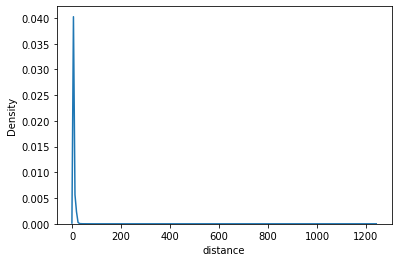

In [188]:
# 그래프를 그려봤을 때 0에 몰려있는 것을 확인했다.
# 로그를 이용해서 정규화를 시켜주자.
sns.kdeplot(data = train, x = 'distance')

In [189]:
# 로그화 작업
train['distance'] = train['distance'].apply(lambda x: np.log1p(x))
test['distance'] = test['distance'].apply(lambda x:np.log1p(x))

## 평균 속도로 군집화 해주기

In [190]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,target,month,day,hour,weekday,distance
0,2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17,0,0.915887
1,2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0,1,1.031786
2,3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11,0,1.999736
3,3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19,0,0.910661
4,2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13,1,0.783427


In [191]:
# def average_sped(df = None):
#   df['time_hour'] = df['target'].apply(lambda x: x/3600)
#   for i in df.index:
#     df.loc[i,'averge_speed'] = df.loc[i,'distance']/df.loc[i,'time_hour']
#   return df


# train = average_speed(train)e

In [192]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'target',
       'month', 'day', 'hour', 'weekday', 'distance'],
      dtype='object')

In [193]:
# KMeans 불러오기
from sklearn.cluster import MiniBatchKMeans

# k-means clustering 실행
# pickup
kmeans = MiniBatchKMeans(n_clusters = 30, batch_size = 1000)
kmeans.fit(train[['pickup_latitude','pickup_longitude']])
train['pickup_clustering']= kmeans.predict(train[['pickup_latitude','pickup_longitude']])
test['pickup_clustering'] = kmeans.predict(test[['pickup_latitude','pickup_longitude']])

# dropoff
kmeans = MiniBatchKMeans(n_clusters = 30, batch_size = 1000)
kmeans.fit(train[['dropoff_latitude','dropoff_longitude']])
train['dropoff_clustering']= kmeans.predict(train[['dropoff_latitude','dropoff_longitude']])
test['dropoff_clustering'] = kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

## store_and_fwd_flag

In [194]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

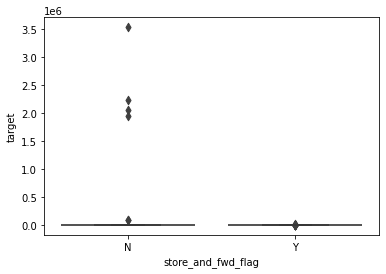

In [195]:
sns.boxenplot(data = train, x = 'store_and_fwd_flag', y = 'target')

- Y가 N보다 더 높은 시간은 나타낸다.

In [196]:
sub_function('store_and_fwd_flag')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


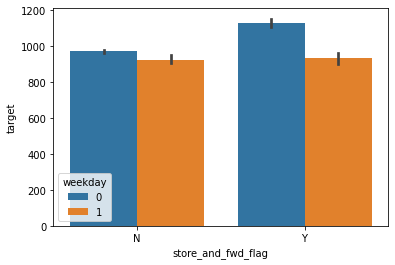

In [197]:
sns.barplot(data = train, x = 'store_and_fwd_flag', y = 'target', hue = 'weekday')

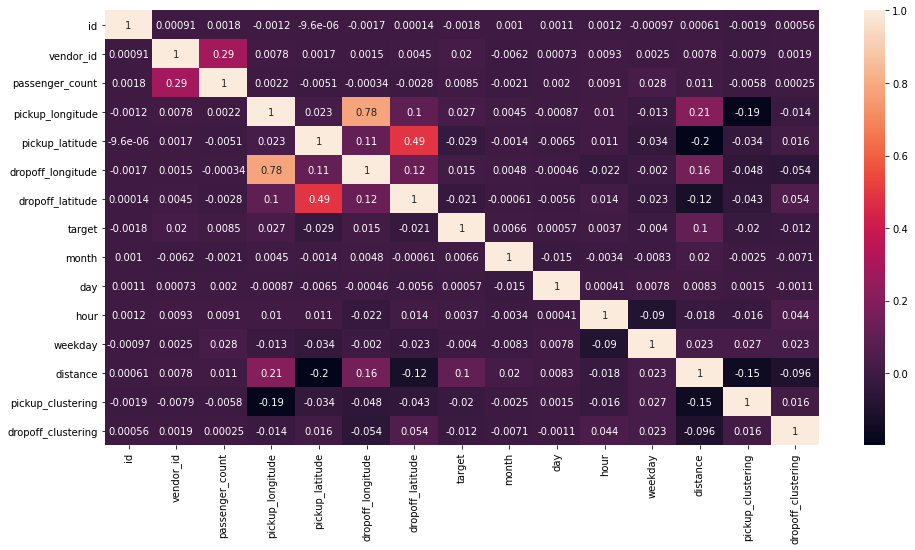

In [198]:
plt.figure(figsize = (16,8))
train_corr=train.corr()
sns.heatmap(train_corr, annot = True)

In [199]:
print('-------- train ----------')
print(train['distance'].describe())
print('------------ test -----------')
print(test['distance'].describe())

-------- train ----------
count    1.458644e+06
mean     1.254794e+00
std      6.272036e-01
min      0.000000e+00
25%      8.029981e-01
50%      1.129586e+00
75%      1.584439e+00
max      7.124718e+00
Name: distance, dtype: float64
------------ test -----------
count    625134.000000
mean          1.254233
std           0.626017
min           0.000000
25%           0.803040
50%           1.129592
75%           1.585919
max           6.944443
Name: distance, dtype: float64


In [200]:
# 그래서 거리의 사분위수를 이용해 나눠주기로 하자.
train['distance'].describe()

train.loc[train['distance'] <= 0.8029981 , 'distance_binning'] = 0
train.loc[(train['distance'] >=0.8029981) & (train['distance'] < 1.129586), 'distance_binning'] = 1
train.loc[(train['distance'] >= 1.129586) & (train['distance'] < 1.584439 ), 'distance_binning'] = 2
train.loc[train['distance'] >= 1.584439, 'distance_binning'] = 3

test.loc[test['distance'] <= 0.803040 , 'distance_binning'] = 0
test.loc[(test['distance'] >= 0.803040) & (test['distance'] < 1.129592), 'distance_binning'] = 1
test.loc[(test['distance'] >= 1.129592) & (test['distance'] < 1.585919 ), 'distance_binning'] = 2
test.loc[test['distance'] >= 1.585919, 'distance_binning'] = 3

In [201]:
# sns.barplot(data = train, x = 'distance_binning', y = 'target')

- 변수마다 연관이 있는 걸로 보여진다.

In [202]:
delete_index=train[(train['passenger_count'] == 7)|(train['passenger_count'] == 8)].index
train=train.drop(delete_index,axis = 0)

sub_function('passenger_count')

train_set 에만 있는 값 set()
test_set 에만 있는 값 set()


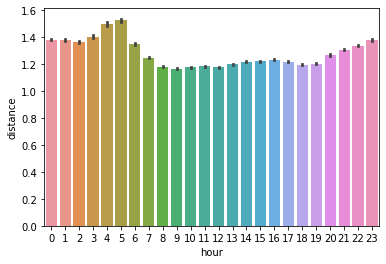

In [203]:
# 3~5시 사이에 높은 이동량을 보인다.
sns.barplot(data = train, x = 'hour', y = 'distance')

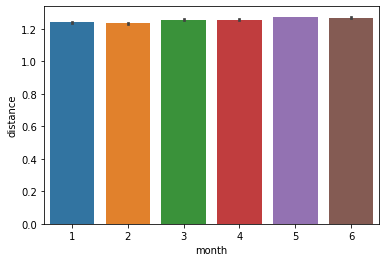

In [204]:
# 눈이 오거나 안오거나에 따라서 거리에 차이가 있을 것 같다.
sns.barplot(data = train, x = 'month', y = 'distance')

# 즉, 눈이 올 시기인 1~2월에는 차들이 좀 더 서행운전을 하기 때문에 목적지에 더 늦게 도착할 것 같다.

### 가정 1 : 날씨가 추운 1~2월은 적은 거리도 추운 날씨 때문에 택시를 탈 것이다.

![%EC%BA%A1%EC%B2%98.PNG](attachment:%EC%BA%A1%EC%B2%98.PNG)

- 변수 0 :1~2월은 겨울인 달
- 변수 1 :3~6월은 겨울이 아닌 달

In [205]:
# 겨울인 1~2월에는 사람들이 적은 거리도 택시를 탈 것이다.
train['cold'] = 1
train.loc[(train['month'] == 1) | (train['month'] == 2), 'cold'] = 0

test['cold'] = 1
test.loc[(test['month'] == 1) | (test['month'] == 2), 'cold'] = 0

In [206]:
train.cold.value_counts()

1    990634
0    468006
Name: cold, dtype: int64

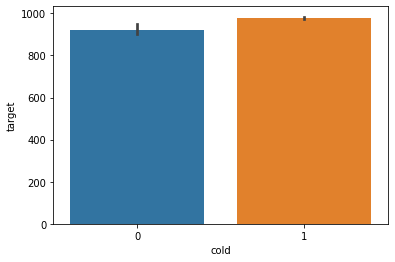

In [207]:
sns.barplot(data = train, x = 'cold', y = 'target')

### 가정 2 :  평일의 일하는 시간대, 일하지 않는 시간대, 주말 이렇게 비교해보도록 하자.
### 2. 일하는 시간대에 사람들이 가장 많이 활동하는 시간대 임으로 도로상황을 고려하여 차를 오래 탄다고 생각한다.
### 1. 주말에 놀러 나가는 사람들이 많으나 일하는 시간대에 비해 차가 안막힌다고 가정한다.
### 0. 평일 일하지 않는 시간대에는 차가 막히지 않으므로 택시를 타고 있는 시간이 적다고 가정했다.

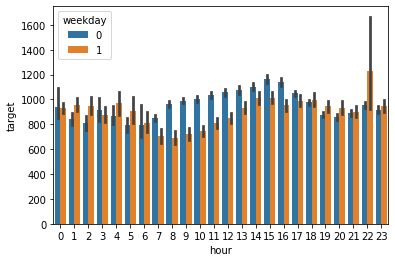

In [208]:
sns.barplot(data = train, x=  'hour', y = 'target', hue = 'weekday')

In [209]:
train.loc[(train['weekday'] == 0), 'working'] = 0
train.loc[train['weekday'] == 1,'working'] = 1
train.loc[(train['weekday'] == 0) & (8 <= train['hour']) & (train['hour'] <= 18), 'working'] = 2

test.loc[(test['weekday'] == 0), 'working'] = 0
test.loc[test['weekday'] == 1,'working'] = 1
test.loc[(test['weekday'] == 0) & (8 <= test['hour']) & (test['hour'] <= 18), 'working'] = 2

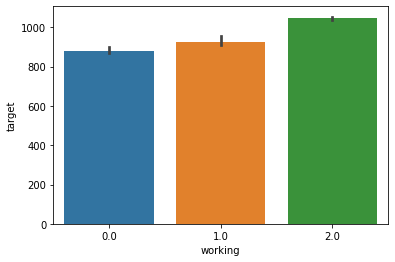

In [210]:
sns.barplot(data = train, x = 'working', y = 'target')

- 유의미한 변수가 될 것 같다.
- 이 변수는 더미화를 시켜주지 않고 넣어주도록 하자.

## 모델링

In [211]:
!pip install catboost

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from xgboost import XGBRFRegressor, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [213]:
dummies=['vendor_id','store_and_fwd_flag','month','hour','weekday','passenger_count','cold','pickup_clustering','dropoff_clustering']
# train 데이터 더미화
data = pd.get_dummies(data = train[dummies], columns = dummies)
train_data = data.copy()

train_data = pd.concat([train_data,train['working']],axis = 1)
# test 데이터 더미화
test_dummies=pd.get_dummies(test[dummies], columns = dummies)
test_data = test_dummies
test_data = pd.concat([test_data,test['working']],axis = 1)

In [214]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


- rmsle를 사용하여 좋은 모델을 골라주고 파라미터를 수정한다.

In [215]:
# 정규분포를 예측하기 위해서 target에 log를 취해준다.
train['log_target'] = train['target'].apply(lambda x:np.log1p(x))

In [223]:
# xgbregressor를 수행해준다.
xgb = XGBRegressor(objective='reg:linear', n_estimators=150, subsample=0.75)
xgb.fit(train_data, train['log_target'])
xgb_pred = xgb.predict(test_data)

# # 예측값을 로그 씌우기 전으로 바꿔준다.
xgb_pred = pd.DataFrame(xgb_pred, columns = ['xgb_pred'])
xgb_pred = xgb_pred['xgb_pred'].apply(lambda x: np.exp(x) - 1)

[14:39:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [217]:
# 0.47691
submission

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959
...,...,...
625129,id3008929,959
625130,id3700764,959
625131,id2568735,959
625132,id1384355,959


In [225]:
# catboostregressor를 수행해준다.
cat = CatBoostRegressor()
cat.fit(train_data, train['log_target'])
cat_pred = cat.predict(test_data)

# 예측값을 로그 씌우기 전으로 바꿔준다.
cat_pred = pd.DataFrame(cat_pred, columns = ['cat_pred'])
cat_pred = cat_pred['cat_pred'].apply(lambda x: np.exp(x) - 1)

Learning rate set to 0.142752
0:	learn: 0.7780151	total: 82.9ms	remaining: 1m 22s
1:	learn: 0.7646100	total: 164ms	remaining: 1m 21s
2:	learn: 0.7542938	total: 244ms	remaining: 1m 21s
3:	learn: 0.7464291	total: 327ms	remaining: 1m 21s
4:	learn: 0.7403022	total: 409ms	remaining: 1m 21s
5:	learn: 0.7339089	total: 488ms	remaining: 1m 20s
6:	learn: 0.7300174	total: 573ms	remaining: 1m 21s
7:	learn: 0.7269065	total: 655ms	remaining: 1m 21s
8:	learn: 0.7203810	total: 738ms	remaining: 1m 21s
9:	learn: 0.7174372	total: 817ms	remaining: 1m 20s
10:	learn: 0.7150345	total: 895ms	remaining: 1m 20s
11:	learn: 0.7101706	total: 976ms	remaining: 1m 20s
12:	learn: 0.7076461	total: 1.05s	remaining: 1m 20s
13:	learn: 0.7028518	total: 1.14s	remaining: 1m 20s
14:	learn: 0.6994926	total: 1.22s	remaining: 1m 19s
15:	learn: 0.6975331	total: 1.29s	remaining: 1m 19s
16:	learn: 0.6938870	total: 1.38s	remaining: 1m 19s
17:	learn: 0.6917505	total: 1.46s	remaining: 1m 19s
18:	learn: 0.6899477	total: 1.54s	remaining

In [219]:
submission

,id,trip_duration
0,id3004672,811.112064
1,id3505355,438.518043
2,id1217141,458.883994
3,id2150126,769.230559
4,id1598245,274.727249
...,...,...
625129,id3008929,229.080190
625130,id3700764,1114.356947
625131,id2568735,1322.358015
625132,id1384355,1483.496278


In [246]:
# y_pred = 0.8*cat_pred + 0.2*xgb_pred # 0.52852
# y_pred = 0.7*cat_pred + 0.3*xgb_pred # 0.51847
# y_pred = 0.6*cat_pred + 0.4*xgb_pred # 0.54801
# y_pred = 0.5*cat_pred + 0.5*xgb_pred # 0.56089
# y_pred = 0.4*cat_pred + 0.6*xgb_pred #
y_pred = 0.3*cat_pred + 0.7*xgb_pred
# y_pred = 0.2*cat_pred + 0.8*xgb_pred



submission['trip_duration'] = y_pred
submission.to_csv("submission.csv", index_label=False, index = False)

In [220]:
# LGBMRegressor를 수행해준다.
# lgb = LGBMRegressor()
# lgb.fit(train_data, train['log_target'])
# lgb_pred = cat.predict(test_data)

# # 예측값을 로그 씌우기 전으로 바꿔준다.
# lgb_pred = pd.DataFrame(lgb_pred, columns = ['lgb_pred'])
# lgb_pred = lgb_pred['lgb_pred'].apply(lambda x: np.exp(x) - 1)

In [221]:
# submission

In [222]:
# # RandomForestRegressor를 수행해준다.
# rfg = RandomForestRegressor(n_estimators=25, min_samples_leaf=25, min_samples_split=25)
# rfg.fit(train_data, train['log_target'])
# y_pred = rfg.predict(test_data)

# # 예측값을 로그 씌우기 전으로 바꿔준다.
# y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])
# y_pred = y_pred['y_pred'].apply(lambda x: np.exp(x) - 1)

# # submission에 저장하여 제출한다.
# submission['trip_duration'] = y_pred
# submission.to_csv("submission.csv", index_label=False, index = False)